# IBM Streams Event Store sample application

This sample demonstrates creating a Streams Python application that ingests data into a Db2 Event Store table and viewing the metrics of the insert operation.

In this notebook, you'll see examples of how to :
 1. [Setup your data connections](#setup)
 2. [Create the application](#create)
 3. [Submit the application](#launch)
 4. [Connect to the running instance to view metrics](#view)
 5. [Stop the application](#cancel)

# Overview

**About the sample**

This application simulates data tuples that are inserted as rows in a Db2 Event Store table.

**How it works**

The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to the service instance from the notebook to retrieve the metrics.

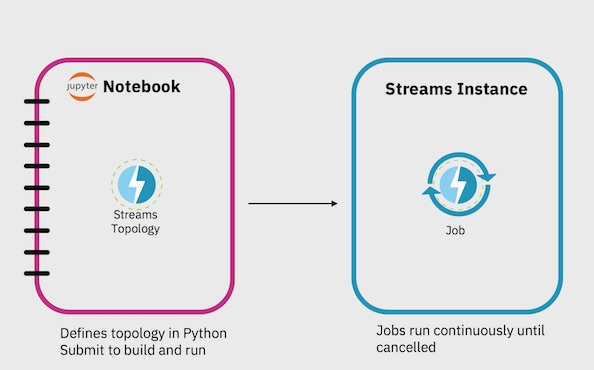


### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [Db2 Event Store install and set up](https://www.ibm.com/support/knowledgecenter/en/SSGNPV_2.0.0/local/installsetup.html)


<a name="setup"></a>
# 1. Setup


### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > instances**.
2. Click the **Provisioned Instances** tab.
3. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

### 1.2 Import  the `streamsx.eventstore` package and verify the package version

In [ ]:
import streamsx.eventstore as es
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.eventstore package version: " + es.__version__)

### 1.3 Configure the connection to Db2 Event Store

Update the name for the EventStore service/instance name.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `eventstore_instance` in the cell below according to your Event Store instance name.
3. Click **View details** for your Event Store instance.
4. Update the values of `es_db` (Database name), `deployment_id` and `es_connection` (Scala Connection URL) in the cell below according to your Event Store instance settings.
5. Set the values for `host` and `port` from Cloud Pak for Data URL

In [ ]:
# Change the name according to your Event Store instance
eventstore_instance = 'EventStore-1'

# Database name
es_db = 'EVENTDB'

# Deployment id
deployment_id = 'db2eventstore-1591210823323'

# Access information: Scala Connection URL
es_connection = # Copy Scala Connection URL from Database Details page

# Cloud Pak for Data host and port, change values below
host = 'zen-cpd-zen.apps.cpd-001.sample.com' # host from Cloud Pak for Data URL
port = '443' # port from Cloud Pak for Data URL

# Cloud Pak for Data project/namespace
prj = 'zen'

#### 1.3.1 SSL - Keystore/Truststore
Functions to retrieve certificate file location and password. Information is mandatory for setting up the SSL connection between Event Store client and server.

In [ ]:
import requests
from icpd_core import icpd_util

def get_certificate(deployment_id):
    """Retrieve keystore and truststore file location for Event Store service in Cloud Pak for Data.
    Example::
        es_truststore, es_keystore = get_certificate(deployment_id)
    Args:
        deployment_id(str): The deployment ID of the Event Store instance
    Returns:
        truststore, keystore
    .. warning:: The function can be used only in Cloud Pak for Data
    """
    clientkeystore = '/user-home/_global_/dbdrivers/eventstore_metadata/'+deployment_id+'/clientkeystore'
    es_truststore = clientkeystore
    es_keystore = clientkeystore
    return es_truststore, es_keystore

def get_keystore_password(deployment_id, host, port, prj):
    """Retrieve keystore password and truststore password for Event Store service in Cloud Pak for Data.
    Example::
        es_truststore_password, es_keystore_password = get_keystore_password(deployment_id, host, port)
    Args:
        deployment_id(str): The deployment ID of the Event Store instance
        host(str): Cloud Pak for Data host
        port(str): Cloud Pak for Data port
    Returns:
        es_truststore_password, es_keystore_password
    .. warning:: The function can be used only in Cloud Pak for Data
    """
    eventstore_cfg=icpd_util.get_service_instance_details(name=eventstore_instance)
    #print(eventstore_cfg)
    token = eventstore_cfg['user_token']

    session=requests.session()
    requests.packages.urllib3.disable_warnings()
    rest_url = 'https://' + host + ':' + port + '/icp4data-databases/'+deployment_id+'/'+prj+'/com/ibm/event/api/v1/oltp/keystore_password'
    print(rest_url)
    response = session.get(rest_url, headers={"Authorization": "Bearer " + token}, verify=False)
    if response.status_code==200:
        es_truststore_password=response.text
        es_keystore_password=es_truststore_password
    return es_truststore_password, es_keystore_password

#### 1.3.2 Setup application configuration

Run the cell below to configure the connection for the IBM Streams application.

The connection details and credentials are stored in an application configuration for IBM Streams application. As name for application configuration is the name of Event Store instance used (`eventstore_instance`). The application configuration contains the following information:
* Name of the database (`es_db`)
* SCALA connection string (`es_connection`)
* Event Store user and password (`es_user` and `es_password`)
* Passwords for SSL certifcates (`es_truststore_password` and `es_keystore_password`)

The "EventStoreWriter" in the application is configured with the name of the application configuration for the connection details stored in the `app_cfg` variable.
Furthermore the "EventStoreWriter" requires the location of the truststore and keystore for the SSL connection (`es_truststore` and `es_keystore`).

In [ ]:
try:
    from streamsx.rest_primitives import Instance
except ImportError:
    # streamsx < 1.15.1
    from streamsx.rest import Instance

import streamsx.topology.context
import streamsx.eventstore as es
import getpass

cfg[streamsx.topology.context.ConfigParams.SSL_VERIFY] = False
instance = Instance.of_service(cfg)

# retrieve certificate location
es_truststore, es_keystore = get_certificate(deployment_id)

# check if application configuration exists
eventstore_app_config = instance.get_application_configurations(name=eventstore_instance)
if eventstore_app_config:
    app_cfg = eventstore_instance
else:
    es_user = input("Event Store user:")
    es_password = getpass.getpass('Event Store password for user '+es_user+':')
    es_truststore_password, es_keystore_password = get_keystore_password(deployment_id, host, port, prj)
    # create application configuration
    app_cfg = es.configure_connection(instance, name=eventstore_instance, database=es_db, connection=es_connection, user=es_user, password=es_password, keystore_password=es_keystore_password, truststore_password=es_truststore_password)

print(app_cfg)

<a id="create"></a>
# 2. Create the application
This application is going to ingest simulated tuples.

These simulated tuples are inserted as rows into a table using Db2 Event Store Scala API. This functionality is provided by `streamsx.eventstore.Insert()` as "EventStoreWriter".

In this example we create a table of two columns:
**| ID:Long  |  NAME:String |**

In the application we define the type `tuple<int64 ID, rstring NAME>` as IBM Streams schema.

Important: The tuple field types and positions in the IBM Streams schema must match the field names in your IBM Db2 Event Store table schema exactly.

Supported types: [Mapping of Event Store types to SPL types](https://ibmstreams.github.io/streamsx.eventstore/doc/spldoc/html/tk$com.ibm.streamsx.eventstore/op$com.ibm.streamsx.eventstore$EventStoreSink$1.html)


In this example, the sharding key and the primary key are defined on the same column `ID`.

Databases in IBM Db2 Event Store are partitioned into shards. Any given IBM Db2 Event Store node (in a multi-node IBM Db2 Event Store cluster) contains 0, 1, or N shards of the defined database. In addition to the mandatory shard key, you can optionally provide a primary key. When you define a primary key, IBM Db2 Event Store ensures that only a single version of each primary key exists in the database.

**If the table does not exist in the database, then the table is created by the "EventStoreWriter".**

All Streams applications start with  a `Topology` object, so start by creating one:


In [ ]:
from streamsx.topology.topology import Topology

topo = Topology(name="EventStoreInsertSample", namespace="sample")

<a id="create"></a>
### 2.0.1 (OPTIONAL) Add downloaded streamsx.eventstore toolkit to the topology

Uncomment the lines in the cell below, if you need to use the latest toolkit downloaded form GitHub.

In [ ]:
#import streamsx.spl.toolkit as toolkit
#import streamsx.eventstore as es
#eventstore_toolkit = es.download_toolkit()
#if eventstore_toolkit is not None: 
#    toolkit.add_toolkit(topo, eventstore_toolkit) # add event store toolkit to topology

## 2.1 Define the application


First step is to define a data source that produces the data being processed.
For this, create a `Stream` called  `pulse` that will contain the simulated data with two attributes.
A `Stream` is a potentially infinite sequence of tuples containing the data to be analyzed.

Next, use the data source `Stream` as input for the "EventStoreWriter".

**Define the table schema**

* The table name is defined in the `table` variable. This is applied as `table` parameter to the `streamsx.eventstore.Insert()` class
* The table schema is specified by the Stream type `tuple<int64 ID, rstring NAME>`
* Primary key of the table is applied as `primary_key` parameter to the `streamsx.eventstore.Insert()` class

In [ ]:
import streamsx.spl.op as op
import streamsx.eventstore as es
from streamsx.topology.schema import StreamSchema
import random
import time


# This application creates a table with the name below
table = 'StreamsEventStoreSampleTable'

def generate_data():
    counter = 0
    while True:
        #yield a random id and name
        yield  {"NAME": "id_" + str(random.randint(0,10)), "ID": counter}
        counter = counter + 1
        time.sleep(0.01)

# convert it to SPL schema for the Event Store operator
tuple_schema = StreamSchema("tuple<int64 ID, rstring NAME>")
# Generates data for a stream of two attributes. Each attribute maps to a column using the same name of the DB2 Event Store table.
pulse = topo.source(generate_data, name="GeneratedData").map(lambda tpl: (tpl["ID"], tpl["NAME"]), schema=tuple_schema)


# configure the number of tuples that are inserted as batch
batch_size=100

# insert tuple data into table as rows
pulse.for_each(es.Insert(config=app_cfg, table=table, batch_size=batch_size, primary_key='ID', partitioning_key='ID', truststore=es_truststore, keystore=es_keystore), name='ES_Inserter')

<a name="launch"></a>

# 3. Submit the application
A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# submit the topology 'topo'
submission_result = context.submit ("DISTRIBUTED", topo, config = cfg)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)

<a name="view"></a>

# 4. Collect metrics from the job
Now that the job is started, connect to the instance and view the metrics of the "Event Store Writer".

The following metrics are collected: 
* nWriteSuccesses - number of successful inserts
* nWriteFailures - number of failed inserts
* insertTimeMin - minimum time of insert operation in ms
* insertTimeAvg - average time of insert operation in ms
* insertTimeMax - maximum time of insert operation in ms
* nActiveInserts - indicates if inserts is active or not (1: active, 0: inactive)

It prints one line per metrics fetch every 5 seconds for 2 minutes.

**Collecting operator metrics**

Each kind of operator provides different metrics with specific names. Find below example code to retrieve all operator metrics from all jobs in a Streams instance:

---------
```
try:
    from streamsx.rest_primitives import Instance
except ImportError:
    # streamsx < 1.15.1
    from streamsx.rest import Instance

from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# Streams instance object
instance = Instance.of_service(cfg)
# Get list of all running jobs in the Streams instance
job_list = instance.get_jobs()
for j in job_list:
    job_id = j.id
    job_name = j.name
    print("JobId: "+job_id + " Name: "+ job_name)
    # Loop over each operator of the job
    op_list = j.get_operators()
    for op in op_list:
        print("Operator name:" + op.name + " kind: " + op.operatorKind)
        # List all metrics of the operator
        m = op.get_metrics()
        if len(m) > 0:
            print("Metric "+m[0].name + ": "+str(m[0].value))
```
---------

In [ ]:
try:
    from streamsx.rest_primitives import Instance
except ImportError:
    # streamsx < 1.15.1
    from streamsx.rest import Instance

import streamsx.topology.context
from time import sleep
from datetime import datetime

# retrieve metrics from submitted job
j = submission_result.job

interval = 5 # collect metrics after n seconds
n = 24 # collect n times, -1 infinite
i = 0
metrics_info = ""
sleep(20) # initial delay since job startup takes some time
while True:
    i = i + 1
    op = j.get_operators('ES_Inserter')[0]
    if op.operatorKind == 'com.ibm.streamsx.eventstore::EventStoreSink':
        time_info = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        for metric in ("nWriteSuccesses","nWriteFailures","insertTimeMin","insertTimeAvg","insertTimeMax","nActiveInserts"):
            m = op.get_metrics(name=metric)
            if len(m) > 0:
                metrics_info = metrics_info + " " + m[0].name + ": " + str(m[0].value)

        print(time_info + " " + metrics_info)
    if i == n:
        break
    sleep(interval)
    metrics_info = ""


## 4.1 See job status 

You can view job status and logs by going to **Projects** > **Jobs**. Find your job based on the id printed above.
Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects** > **Jobs**. Select "View graph" action for the running job.


<a name="cancel"></a>

# 5. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.

In [ ]:
# cancel the job directly using the Job object
streams_job.cancel()

# Summary

We started with a `Stream` called `pulse`, which contained the data we wanted to insert. Next, we used the `pulse` stream as input for the "Event Store Writer" to insert rows in the specified table.  

After submitting the application to the Streams service, we connected to the instance via REST and displayed the "Event Store Writer" metrics to see the progress within the notebook.